In [1]:
import nltk
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random
import sklearn

In [2]:
#nltk.download('brown')

In [3]:
tagged_sent = nltk.corpus.brown.tagged_sents()

In [4]:
#shaping data [(sentence,tags),(sentence,tags)...]
data_set=[]
untag_sent = []
for sentence in tagged_sent :
    words=[]
    tags=[]
    words = [w[0] for w in sentence]
    tags = [w[1] for w in sentence]
    untag_sent.append(words)
    data_set.append((words,tags))

#spliting the data : training 60%, validation 25%, test 15%
train_length = int(0.6*len(data_set))
val_length = int(0.85*len(data_set))

training_set = data_set[:5000]
#untag_training_set = untag_sent[:500]

validation_set = data_set[5000:7000]
#untag_validation_set = untag_sent[500:600]

test_set = data_set[7000:8000]
#untag_test_set = untag_sent[6000:6500]

In [5]:
#creates one dictionary of all the tags and an other of all the words in the corpus
word_to_ix = {}
tag_dic ={}
for sent, tags in data_set:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
    for tag in tags :
        if tag not in tag_dic :
            tag_dic[tag] = len(tag_dic)

#shaping the data
def prepare_sequence(seq, to_ix):
    #turn the words of a sentence into its word dictionary index
    idxs = [to_ix[w] for w in seq]
    tensor = torch.LongTensor(idxs)
    return autograd.Variable(tensor)

EMBEDDING_DIM = 300
HIDDEN_DIM = 200

In [6]:
# from http://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

class LSTMTagger(nn.Module):
    
    def __init__(self, embedding_dim, hidden_dim, vocab_size, target_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
        
        self.word_embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        
        self.hidden2tag = nn.Linear(hidden_dim, target_size)
        self.hidden = self.init_hidden()
        
    def init_hidden(self):
        return(autograd.Variable(torch.zeros(1, 1, self.hidden_dim)),
              autograd.Variable(torch.zeros(1, 1, self.hidden_dim)))
    
    def forward(self, sentence):
        embeds = self.word_embedding(sentence)
        lstm_out, self.hidden = self.lstm(embeds.view(len(sentence), 1, -1), self.hidden)
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return(tag_scores)

epoch
validation
epoch
validation
epoch
validation
epoch
validation
epoch
validation
epoch
validation
epoch
validation
epoch
validation
epoch
validation
epoch
validation


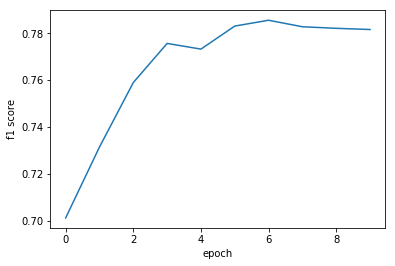

In [7]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_dic))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

loss = 0
#average accuracy of each validation set
validation_f1score = []
#store the loss after each iteration
#total_loss=[]
for epoch in range(10): 
    print('epoch')
    #shuffle data
    np.random.shuffle(training_set)
    np.random.shuffle(validation_set)
    #training loop
    for sentence, tags in training_set:
        #clear the gradient before each instance
        model.zero_grad()
        #clear out the hidden state of the lstm
        #detaching it from its history on the last instance
        model.hidden = model.init_hidden()
        
        #get the inputs ready for the network : turn them into variable of word indices
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_dic)
        
        #forward pass
        tag_scores = model(sentence_in)
        #to get the rigth prediction, choose the index of the max for each row
        #_,tag_pred = torch.max(tag_scores,dim = 1)

        #compute the loss, gradient, and update the parameters 
        loss = loss_function(tag_scores, targets) #tag_scores ou tag_pred ???????
        loss.backward()
        optimizer.step()
        #total_loss.append(loss)
        
    print('validation')
    #validation loop
    #store the f1 score of each sentence
    sent_f1score = []
    for sentence, tags in validation_set :
        model.zero_grad()
        model.hidden = model.init_hidden()
        sentence_in = prepare_sequence(sentence, word_to_ix)
        #making predictions
        _,tags_predictions = torch.max(model(sentence_in), dim=1)

        #computing targets
        targets = prepare_sequence(tags, tag_dic)
        
        #list in wich we store the rigth predictions for the given setence
        sentence_prediction = []
        
        for i in range(len(targets)) :
            #for each word, one if it's the good tag, 0 otherwise
            sentence_prediction.append(int(targets[i]==tags_predictions[i]))
            
        #computing the f1 score over the validation set
        array_target = targets.data.numpy()
        array_pred = tags_predictions.data.numpy()
        sent_f1score.append(sklearn.metrics.f1_score(array_target,array_pred,average='micro'))
                                                     
    validation_f1score.append(np.average(sent_f1score))    
plt.plot(validation_f1score)
plt.xlabel('epoch')
plt.ylabel('f1 score')
#plt.savefig("f1_score_lstm.pdf")

In [8]:
#predictions on the test set
#test_error_rate = 0
test_sent_f1score = []
for sentence, tags in test_set :
        model.zero_grad()
        model.hidden = model.init_hidden()
        sentence_in = prepare_sequence(sentence, word_to_ix)
        #making the predictions
        _,tags_predictions = torch.max(model(sentence_in), dim=1)

        #computing the f1 score
        targets = prepare_sequence(tags, tag_dic)
        
        sentence_prediction = []
        
        for i in range(len(targets)) :
            #for each word, one if it's the good tag, 0 otherwise
            sentence_prediction.append(int(targets[i]==tags_predictions[i]))
            
        #convert tags and predictions to the numpy array
        array_target = targets.data.numpy()
        array_pred = tags_predictions.data.numpy()
        #store the f1 score of each sentence
        test_sent_f1score.append(sklearn.metrics.f1_score(array_target,array_pred,average='micro'))

f1_score = np.average(test_sent_f1score)
print('test f1 score')
print(f1_score)

test f1 score
0.7875683824690193
